# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [ ]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [ ]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## Visualize the dataset

5


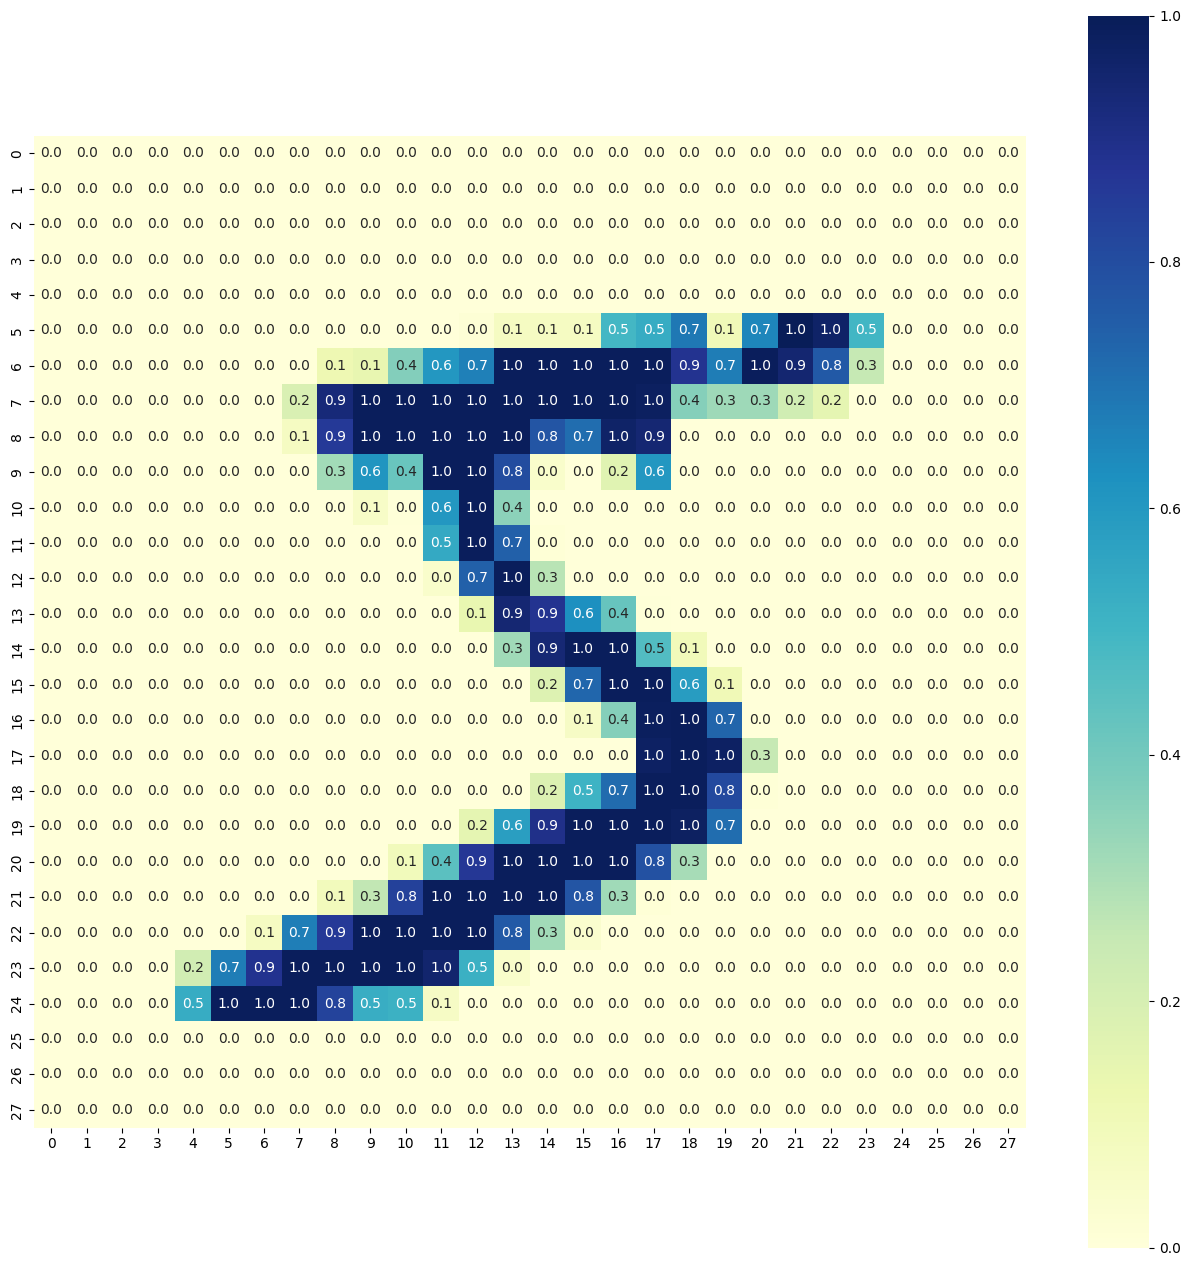

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 0

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## Install a library for plotting loss and accuracy values

In [ ]:
!pip install livelossplot

## Perceptron algorithm for single-layer neural network

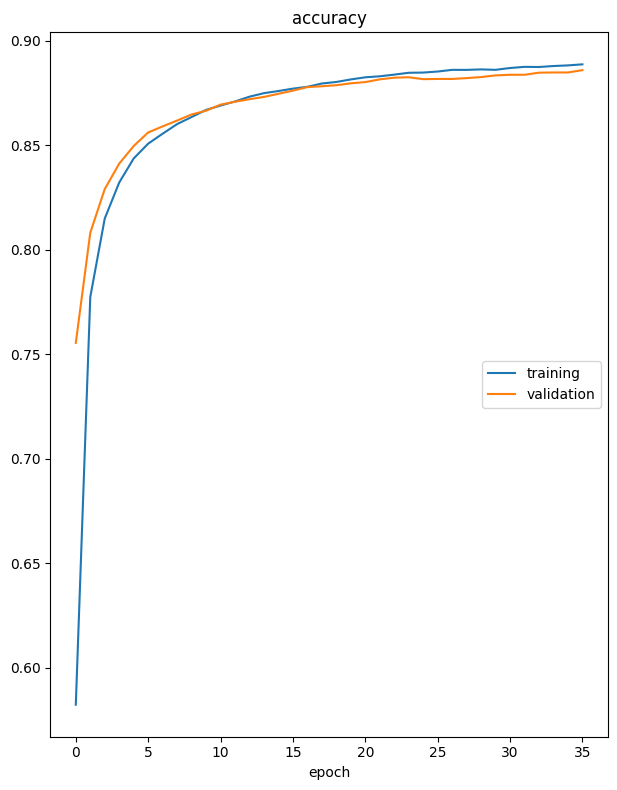

accuracy
	training         	 (min:    0.582, max:    0.889, cur:    0.889)
	validation       	 (min:    0.755, max:    0.886, cur:    0.886)


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

## Stochastic gradient descent for single-layer neural network

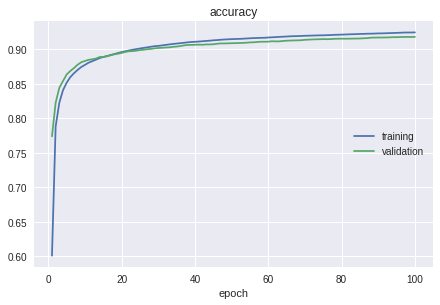

Accuracy: 0.9182 (test), 0.9246 (train)


In [ ]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    num_correct_train = 0

    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest),
    float(num_correct_train) / len(Ytrain)
    ))

## Training with pytorch

### Install pytorch

In [ ]:
!pip install torch torchvision

### Convert the numpy arrays into pytorch tensor

In [ ]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

### Single-layer neural network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

def create_dataset(x, y):
    xt = torch.from_numpy(x).view(len(x), -1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for t in range(100):
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        # Compute the loss value.
        loss = loss_fn(y_pred, y)

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

Sequential(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


TypeError: ignored

### Three-layer neural network

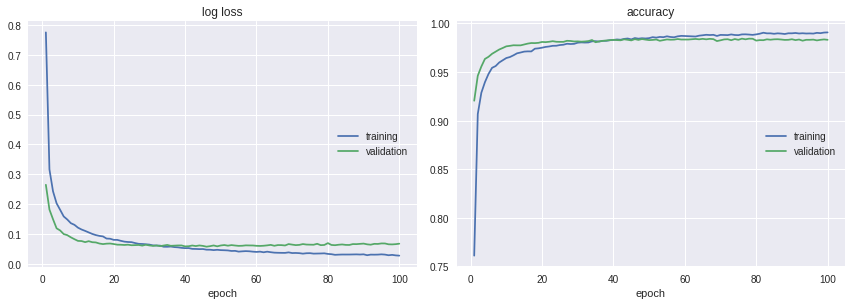

Accuracy: 0.9832 (test), 0.9908 (train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

### Convolutional Neural Network (CNN)

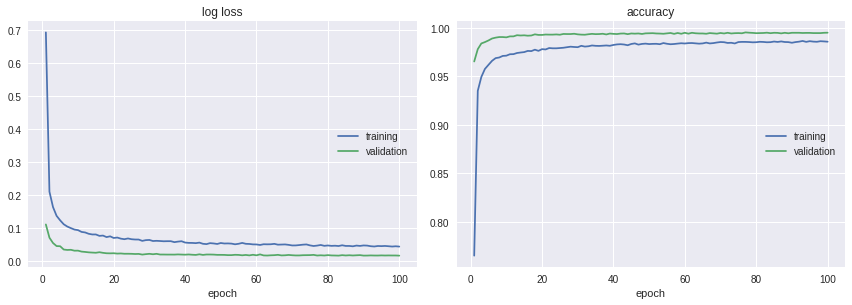

Accuracy: 0.9949 (test), 0.9856 (train)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

In [ ]:

import torch
import torch.nn as nn
data = "Transformers is a media franchise produced by American toy company Hasbro and Japanese toy company Takara Tomy   It primarily follows the heroic Autobots and the villainous Decepticons   two alien robot factions at war that can transform into other forms   such as vehicles and animals   The franchise encompasses toys   animation   comic books   video games and films   As of            it generated more than      trillion          billion   in revenue         making it one of the highest  grossing media franchises of all time  The franchise began in          with the Transformers toy line   comprising transforming mecha toys from Takara  s Diaclone and Micro Change toylines rebranded for Western markets         The term   Generation      covers both the animated television series The Transformers and the comic book series of the same name   which are further divided into Japanese   British and Canadian spin  offs   respectively   Sequels followed   such as the Generation    comic book and Beast Wars TV series   which became its own mini  universe   Generation    characters underwent two reboots with Dreamwave Productions in          and IDW Publishing in            with a third starting in            There have been other incarnations of the story based on different toy lines during and after the     th century   The first was the Robots in Disguise series   followed by three shows   Armada   Energon   and Cybertron   that constitute a single universe called the   Unicron Trilogy    A live  action film series started in            again distinct from previous incarnations   while the Transformers   Animated series merged concepts from the G   continuity   the          live  action film and the   Unicron Trilogy     For most of the         s   in an attempt to mitigate the wave of reboots   the   Aligned Continuity   was established   In            Transformers   Cyberverse debuted   once again   distinct from the previous incarnations  Although initially a separate and competing franchise started in            Tonka  s GoBots became the intellectual property of Hasbro after their buyout of Tonka in            Subsequently   the universe depicted in the animated series Challenge of the GoBots and follow  up film GoBots   Battle of the Rock Lords was retroactively established as an alternate universe within the Transformers multiverse        FictionTransformers   Generation                          Main articles   Transformers   Generation    and The Transformers   TV series  Classic Transformers franchise logo used until         Spider  Man battles Megatron on the cover of The Transformers       Generation One is a retroactive term for the Transformers characters that appeared between          and            The Transformers began with the         s Japanese toy lines Micro Change and Diaclone   They presented robots able to transform into everyday vehicles   electronic items or weapons   Hasbro bought the Micro Change and Diaclone toys   and partnered with Takara         Marvel Comics was hired by Hasbro to create the backstory   editor  in  chief Jim Shooter wrote an overall story   and gave the task of creating the characters to writer Dennis O  Neil         Unhappy with O  Neil  s work   although O  Neil created the name   Optimus Prime       Shooter chose Bob Budiansky to create the characters        The Transformers mecha were largely designed by Shōji Kawamori   the creator of the Japanese mecha anime franchise Macross   which was adapted into the Robotech franchise in North America           Kawamori came up with the idea of transforming mechs while working on the Diaclone and Macross franchises in the early         s   such as the VF     Valkyrie in Macross and Robotech     with his Diaclone mechs later providing the basis for Transformers        The primary concept of Generation One is that the heroic Optimus Prime   the villainous Megatron   and their finest soldiers crash land on pre  historic Earth in the Ark and the Nemesis before awakening in            Cybertron hurtling through the Neutral zone as an effect of the war   The Marvel comic was originally part of the main Marvel Universe   with appearances from Spider  Man and Nick Fury   plus some cameos         as well as a visit to the Savage Land          The Transformers TV series began around the same time   Produced by Sunbow Productions and Marvel Productions   later Hasbro Productions   from the start it contradicted Budiansky  s backstories   The TV series shows the Autobots looking for new energy sources   and crash landing as the Decepticons attack           Marvel interpreted the Autobots as destroying a rogue asteroid approaching Cybertron           Shockwave is loyal to Megatron in the TV series   keeping Cybertron in a stalemate during his absence           but in the comic book he attempts to take command of the Decepticons           The TV series would also differ wildly from the origins Budiansky had created for the Dinobots                   the Decepticon turned Autobot Jetfire           known as Skyfire on TV             the Constructicons   who combine to form Devastator                     and Omega Supreme                   The Marvel comic establishes early on that Prime wields the Creation Matrix   which gives life to machines   In the second season   the two  part episode The Key to Vector Sigma introduced the ancient Vector Sigma computer   which served the same original purpose as the Creation Matrix   giving life to Transformers     and its guardian Alpha Trion  In            the cartoon became the film The Transformers   The Movie   which is set in the year            It introduced the Matrix as the   Autobot Matrix of Leadership     as a fatally wounded Prime gives it to Ultra Magnus   however   as Prime dies he drops the matrix   which is then caught by Hot Rod who subsequently becomes Rodimus Prime later on in the film   Unicron   a transformer who devours planets   fears its power and recreates a heavily damaged Megatron as Galvatron   as well as Bombshell or Skywarp becoming Cyclonus   Thundercracker becoming Scourge and two other Insecticons becoming Scourge  s huntsmen   the Sweeps   Eventually   Rodimus Prime takes out the Matrix and destroys Unicron           In the United Kingdom   the weekly comic book interspliced original material to keep up with U  S   reprints           and The Movie provided much new material   Writer Simon Furman proceeded to expand the continuity with movie spin  offs involving the time travelling Galvatron                   The Movie also featured guest voices from Leonard Nimoy as Galvatron   Scatman Crothers as Jazz   Casey Kasem as Cliffjumper   Orson Welles as Unicron and Eric Idle as the leader of the Junkions   Wreck  Gar   though unnamed in the movie     The Transformers theme tune for the film was performed by Lion with   Weird Al   Yankovic adding a song to the soundtrack  The third season followed up The Movie   with the revelation of the Quintessons having used Cybertron as a factory   Their robots rebel   and in time the workers become the Autobots and the soldiers become the Decepticons     Note   This appears to contradict background presented in the first two seasons of the series     It is the Autobots who develop transformation           Due to popular demand           Optimus Prime is resurrected at the conclusion of the third season           and the series ended with a three  episode story arc   However   the Japanese broadcast of the series was supplemented with a newly produced OVA   Scramble City   before creating entirely new series to continue the storyline   ignoring the          end of the American series   The extended Japanese run consisted of The Headmasters   Super  God Masterforce   Victory and Zone   then in illustrated magazine form as Battlestars   Return of Convoy and Operation   Combination   Just as the TV series was wrapping up   Marvel continued to expand its continuity   It followed The Movie  s example by killing Prime         and Megatron           albeit in the present day   Dinobot leader Grimlock takes over as Autobot leader           There was a G  I   Joe crossover         and the limited series The Transformers   Headmasters   which further expanded the scope to the planet Nebulon           It led on to the main title resurrecting Prime as a Powermaster          "


#"The franchise began in 1984 with the Transformers toy line, comprising transforming mecha toys from Takara's Diaclone and Micro Change toylines rebranded for Western markets.[2] The term Generation 1 covers both the animated television series The Transformers and the comic book series of the same name, which are further divided into Japanese, British and Canadian spin-offs, respectively. Sequels followed, such as the Generation 2 comic book and Beast Wars TV series, which became its own mini-universe. Generation 1 characters underwent two reboots with Dreamwave Productions in 2001 and IDW Publishing in 2005, with a third starting in 2019. There have been other incarnations of the story based on different toy lines during and after the 20th century. The first was the Robots in Disguise series, followed by three shows (Armada, Energon, and Cybertron) that constitute a single universe called the Unicron Trilogy"

data = data.replace(".", "")
data.replace(",","")

data = data.lower()
data = data.split(" ")


uniques = len(set(data))
print(uniques)
words = list(set(data))

numdata = []
for word in data:
  numdata.append(words.index(word))

numdata = torch.IntTensor(numdata)
print(numdata)

519
tensor([381,  41, 322,  ...,   0,   0,   0], dtype=torch.int32)


In [ ]:

import math



class self_attention(nn.Module):
  def __init__(self):
    super().__init__()

    self.Q = nn.Linear(12, 12)
    self.K = nn.Linear(12, 12)
    self.V = nn.Linear(12, 12)
    self.softmax = nn.Softmax(dim=0)
    self.embedding = nn.Embedding(519,12)
    self.flatten = nn.Flatten(start_dim=0)
    self.preoutput = nn.Linear(144,512)
    self.gelu = nn.GELU()
    self.output = nn.Linear(512, 519)

  def forward(self, x):
    x = self.embedding(x)
    x_q = self.Q(x)
    x_k = self.K(x)
    x_v = self.V(x)
    x_qk =  x_q.matmul(x_k.transpose(0,1))/math.sqrt(12)
    x = self.softmax(x_qk).matmul(x_v)
    x = self.flatten(x)
    x=self.preoutput(x)
    x = self.gelu(x)
    x = self.output(x)

    return x


self_atten = self_attention()

p = self_atten(numdata[:12])

optimizer = torch.optim.Adam(self_atten.parameters(), lr = 0.0001)
loss = nn.CrossEntropyLoss()

for i in range(100):
  for i in range(len(numdata)-13):
    optimizer.zero_grad()
    x = numdata[i:i+12]
    y = torch.zeros(519)
    y[numdata[i+13]] = 1
    y_p = self_atten(x)
    l = loss(y_p, y)
    print(l)
    l.backward()
    optimizer.step()


p = self_atten(numdata[:12])

print(p, words[p.argmax()], data[13])

for i in range(len(numdata)-13):
  x = numdata[i:i+12]
  y = data[i+13]
  y_p = self_atten(x)
  #print(y, words[y_p.argmax()])
  if y != words[y_p.argmax()]:
    print("Wrong!")







Streaming output truncated to the last 5000 lines.
tensor(1.1921e-06, grad_fn=<DivBackward1>)
tensor(2.3842e-07, grad_fn=<DivBackward1>)
tensor(7.1526e-07, grad_fn=<DivBackward1>)
tensor(0.0009, grad_fn=<DivBackward1>)
tensor(0.0004, grad_fn=<DivBackward1>)
tensor(0.0005, grad_fn=<DivBackward1>)
tensor(0.0003, grad_fn=<DivBackward1>)
tensor(0.0005, grad_fn=<DivBackward1>)
tensor(-0., grad_fn=<DivBackward1>)
tensor(0.0007, grad_fn=<DivBackward1>)
tensor(2.1458e-06, grad_fn=<DivBackward1>)
tensor(0.0001, grad_fn=<DivBackward1>)
tensor(0.0008, grad_fn=<DivBackward1>)
tensor(1.7285e-05, grad_fn=<DivBackward1>)
tensor(0.0003, grad_fn=<DivBackward1>)
tensor(-0., grad_fn=<DivBackward1>)
tensor(3.4212e-05, grad_fn=<DivBackward1>)
tensor(8.9407e-06, grad_fn=<DivBackward1>)
tensor(0.0003, grad_fn=<DivBackward1>)
tensor(2.2769e-05, grad_fn=<DivBackward1>)
tensor(0.0010, grad_fn=<DivBackward1>)
tensor(8.3681e-05, grad_fn=<DivBackward1>)
tensor(0.0005, grad_fn=<DivBackward1>)
tensor(0.0002, grad_fn